In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import SinkhornImputation_CMI
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\adult\adult_data_without_missing_values.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [5]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

13.175192739902075
-3.727580874154209
-1.150625605038418e-17
-0.19623778646170578
1.0


In [6]:
print(ground_truth_numpy)

[[ 0.03420095 -1.90309934 -1.06229487 ... -0.21878026 -0.07812006
  -0.19623779]
 [ 0.86641684  1.9863551  -1.00743773 ... -0.21878026 -2.32673801
  -0.19623779]
 [-0.04145504  0.04162788  0.24528351 ... -0.21878026 -0.07812006
  -0.19623779]
 ...
 [-0.04145504  0.04162788  1.75361345 ... -0.21878026  0.7547014
  -0.19623779]
 [ 0.4124809   0.04162788 -1.00194728 ... -0.21878026 -0.07812006
  -0.19623779]
 [-0.26842301  1.9863551  -0.07181821 ... -0.21878026  1.58752287
  -0.19623779]]


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(45222, 13)


tensor(0)


In [8]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.301


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.04%


In [9]:
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()

In [10]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
#epsilon_mcar30 = pick_epsilon(data_mcar30)
epsilon_mcar30 = 0.3
print(epsilon_mcar30)


0.3


In [11]:
sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,sk_loss_mcar30 = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=50, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 3.2405	 Validation MAE: 0.6906	RMSE: 1.0049
INFO:root:Iteration 50:	 Loss: 2.7209	 Validation MAE: 0.6846	RMSE: 1.0040
INFO:root:Iteration 100:	 Loss: 3.4733	 Validation MAE: 0.6789	RMSE: 1.0029
INFO:root:Iteration 150:	 Loss: 2.8612	 Validation MAE: 0.6737	RMSE: 1.0022
INFO:root:Iteration 200:	 Loss: 2.2189	 Validation MAE: 0.6688	RMSE: 1.0012
INFO:root:Iteration 250:	 Loss: 3.5109	 Validation MAE: 0.6642	RMSE: 1.0004
INFO:root:Iteration 300:	 Loss: 2.1116	 Validation MAE: 0.6600	RMSE: 0.9998
INFO:root:Iteration 350:	 Loss: 2.9815	 Validation MAE: 0.6557	RMSE: 0.9989
INFO:root:Iteration 400:	 Loss: 2.5817	 Validation MAE: 0.6518	RMSE: 0.9984
INFO:root:Iteration 450:	 Loss: 2.3948	 Validation MAE: 0.6482	RMSE: 0.9979
INFO:root:Iteration 500:	 Loss: 3.0436	 Validation MAE: 0.6446	RMSE: 0.9973
INFO:root:Iteration 550:	 Loss: 2.5744	 Validation MAE: 0.6415	RMSE: 0.9971
INFO:root:Iteration 600:	 Loss: 2.4610	 Validation MAE: 0.6384	RMSE: 0.9966
INFO:root:Itera

0.5898996706592428 0.9865765634678498


In [12]:
print(sk_loss_mcar30)
#sk_loss_mcar30.clear

[3.240521455636049, 2.7208808685694024, 3.4733470221266693, 2.8611949954307807, 2.218872251670016, 3.5109158452997677, 2.1116315145232907, 2.9814992047170943, 2.5816813138915937, 2.394842097395668, 3.0436051937558277, 2.5744140313441886, 2.460972714153689, 2.6817825737776695, 2.2555889079095506, 2.601630508279393, 2.340151516229774, 2.3281421963385984, 2.192563776075799, 2.4433084782236314, 2.738899445226368, 2.476273333685884, 2.4693183289960574, 2.331373681221456, 2.75526671719101, 2.3295333171757004, 2.7133230005900533, 2.913163871102526, 2.715436181488114, 2.8516782386658512, 3.0684807791352045, 3.4841785405205767, 2.2629535153069797, 3.3594243660002108, 2.9157223837635566, 2.71938557066921, 2.5602255889950287, 2.485328650657558, 2.259508610893746, 2.6843155369983585]


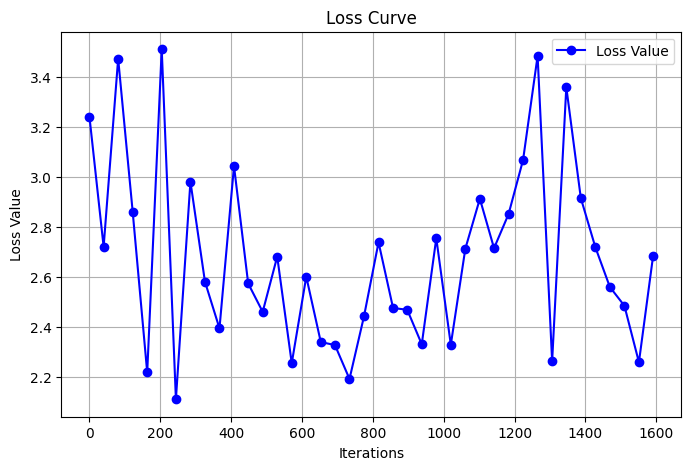

In [13]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = sk_loss_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [14]:
loss_values.clear

<function list.clear()>

In [15]:
sk_imp_mcar30

tensor([[ 0.0342, -1.9031, -1.0623,  ..., -0.1770, -0.0781, -0.1962],
        [-0.0171,  0.0283, -0.0150,  ..., -0.2188, -2.3267, -0.1962],
        [-0.3154,  0.0416,  0.2453,  ..., -0.2188,  0.1150, -0.1962],
        ...,
        [-0.0506,  0.0416,  1.7536,  ..., -0.2188,  0.1887, -0.1962],
        [ 0.4125,  0.0416, -1.0019,  ..., -0.2188,  0.0599, -0.0616],
        [-0.0097,  0.0786, -0.1830,  ..., -0.2188,  0.2642, -0.1962]],
       grad_fn=<IndexPutBackward0>)

In [16]:
import pandas as pd
import numpy as np

# Assuming 'data_imputed_df' is your dataset with z-scores
# Get the mean and standard deviation for each column (feature) before transformation

column_names = [
    "age", "workclass", "fnlwgt", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country"
]
data = pd.DataFrame(Xy['data'], columns=column_names)
mean_values_sex = data['sex'].mean()
std_values_sex = data['sex'].std()

mean_values_education = data['education-num'].mean()
std_values_education = data['education-num'].std()
# Reversing the z-score transformation
def reverse_z_score_sex(d):
    # Apply the reverse formula for each column
    return (d * std_values_sex + mean_values_sex)

def reverse_z_score_education(d):
    # Apply the reverse formula for each column
    return (d * std_values_education + mean_values_education)

  




In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Replace this with the actual imputed dataset you are working with

column_names = [
    "age", "workclass", "fnlwgt", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country"
]

# Convert your numpy array into a pandas DataFrame (assuming your dataset is imputed)
data_imputed_df = pd.DataFrame(sk_imp_mcar30_numpy, columns=column_names)
data_imputed_df['target'] = Xy['target']
data_imputed_df['sex'] = reverse_z_score_sex(data_imputed_df['sex'])
data_imputed_df['education-num'] = reverse_z_score_sex(data_imputed_df['education-num'])


# Now 'original_data' will contain the reversed values (original data)
print(data_imputed_df.head(7))


# Calculate Mutual Information between X and Y
def compute_mutual_information(X, Y):
    return mutual_info_score(X, Y)


# Compute Mutual Information between 'sex' and 'age'
mi_sex_target = compute_mutual_information(data_imputed_df['sex'], data_imputed_df['target'])

# Compute Mutual Information between 'sex' and 'education-num'
mi_sex_education = compute_mutual_information(data_imputed_df['sex'], data_imputed_df['education-num'])

# Compute Mutual Information between 'age' and 'education-num'
mi_target_education = compute_mutual_information(data_imputed_df['target'], data_imputed_df['education-num'])

# Calculate Conditional Mutual Information: I(X; Y | Z)
# I(sex; age | education-num) = I(sex; age) - I(sex; education-num) - I(age; education-num)
cmi_sex_target_education = mi_sex_target - mi_sex_education - mi_target_education

# Output the result
print(f"Conditional Mutual Information I(sex; target | education-num): {cmi_sex_target_education}")


        age  workclass    fnlwgt  education-num  marital-status  occupation  \
0  0.034201  -1.903099 -1.062295       1.853618       -0.361395   -0.481130   
1 -0.017096   0.028339 -0.015005       1.853618       -0.957783   -1.102577   
2 -0.315390   0.041628  0.245284       1.198342        0.176626   -0.141848   
3  1.093385  -0.040166  0.425853       1.220591       -0.957783    0.022188   
4 -0.798015   0.041628  1.407393       1.853618        0.257111   -0.060020   
5 -0.117111  -0.067902  0.897852       1.318448       -0.957783   -1.102577   
6  0.790761  -0.005083 -0.279707       0.385888       -0.957783    0.251535   

   relationship      race       sex  capital-gain  capital-loss  \
0     -0.433421 -0.403026  0.999996      0.142888     -0.177029   
1      0.166132 -0.403026  1.505413     -0.097937     -0.218780   
2     -0.350827 -0.403026  0.999996     -0.146733     -0.218780   
3     -0.953975  2.481232  0.999996     -0.146733     -0.218919   
4      0.081966  2.481232  2.000

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [18]:
data_imputed_df['target'].unique()

array([0, 2, 1, 3])